In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = MinMaxScaler()
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
target_col = 'Exited'
df.head()

def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

In [21]:
df.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['Exited']), df['Exited'], test_size=0.2, random_state=12)
numeric_cols = X_train.select_dtypes(include='number').columns
numeric_cols
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [22]:
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

encoder.fit(X_train[['Geography']])

encoded_cols = list(encoder.get_feature_names_out(['Geography']))

X_train[encoded_cols] = encoder.transform(X_train[['Geography']])
X_val[encoded_cols] = encoder.transform(X_val[['Geography']])
df_test[encoded_cols] = encoder.transform(df_test[['Geography']])

X_train['isMale'] = X_train['Gender'].map( {'Male': 1, 'Female': 0})
df_test['isMale'] = df_test['Gender'].map( {'Male': 1, 'Female': 0})
X_val['isMale'] = X_val['Gender'].map( {'Male': 1, 'Female': 0})

encoded_cols.append("isMale")

model = LogisticRegression(
    solver='liblinear',
    C=10,          # трохи сильніша регуляризація
    max_iter=10000
)
numeric_cols = numeric_cols.tolist()
all_cols = numeric_cols + encoded_cols
model.fit(X_train[all_cols], y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",10
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mult

In [23]:
train_probs = model.predict_proba(X_train[numeric_cols+encoded_cols])
print(train_probs[:5])  
#plt.hist(train_probs[:,1])
y_train.value_counts(normalize=True)
model_pipeline = joblib.load('model_pipeline_poly.pkl')
train_probs = model_pipeline.predict_proba(X_train)
print(train_probs[:5])

[[0.97383941 0.02616059]
 [0.78162    0.21838   ]
 [0.13938392 0.86061608]
 [0.10401624 0.89598376]
 [0.99447155 0.00552845]]
[[0.29216529 0.70783471]
 [0.83573915 0.16426085]
 [0.0361423  0.9638577 ]
 [0.16434254 0.83565746]
 [0.35034622 0.64965378]]


In [24]:
from sklearn.metrics import accuracy_score
train_preds = model_pipeline.predict(X_train)
accuracy_score(y_train, train_preds)

0.532

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, train_preds)
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

In [26]:
train_preds = predict_and_plot(X_train[numeric_cols+encoded_cols], y_train, 'Training')

AttributeError: 'DataFrame' object has no attribute 'predict'

Accuracy: 86.63%


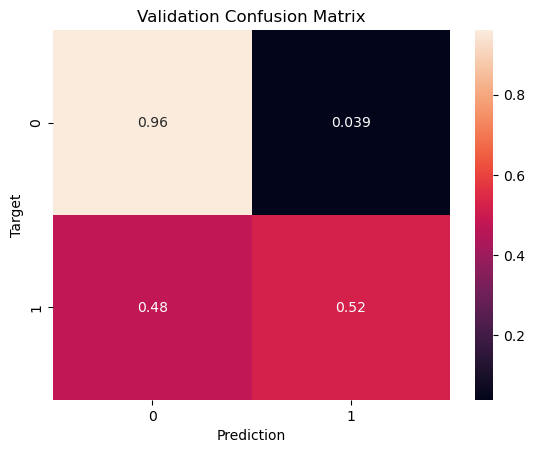

In [ ]:
val_preds = predict_and_plot(X_val[numeric_cols+encoded_cols], y_val, 'Validation')

0.0006226036118680119 0.9984640153386616


(array([5287., 1564.,  785.,  453.,  385.,  334.,  325.,  297.,  318.,
         252.]),
 array([6.22603612e-04, 1.00406745e-01, 2.00190886e-01, 2.99975027e-01,
        3.99759168e-01, 4.99543309e-01, 5.99327451e-01, 6.99111592e-01,
        7.98895733e-01, 8.98679874e-01, 9.98464015e-01]),
 <BarContainer object of 10 artists>)

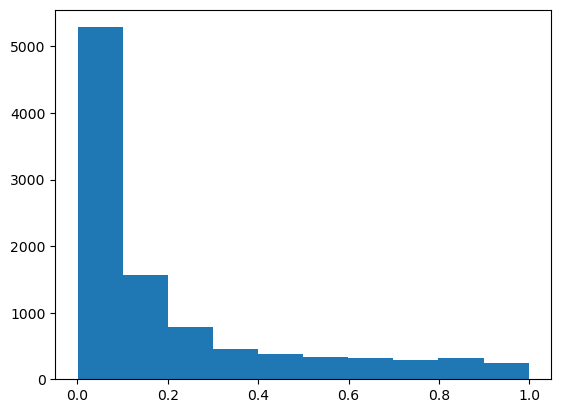

In [ ]:
test_probs = model.predict_proba(df_test[all_cols])[:,1]
print(test_probs.min(), test_probs.max())
test_probs_rounded = np.round(test_probs, 1)

submission = pd.DataFrame({
    'id': df_test['id'],   
    'Exited': test_probs_rounded
})

submission.to_csv('submission.csv', index=False)
plt.hist(test_probs)